In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]

/tmp/ipykernel_1066/1609591717.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


# Create Network Visualizations per (Merged) Cabinet Period

warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied
warning, no disparity and/or weight filter applied


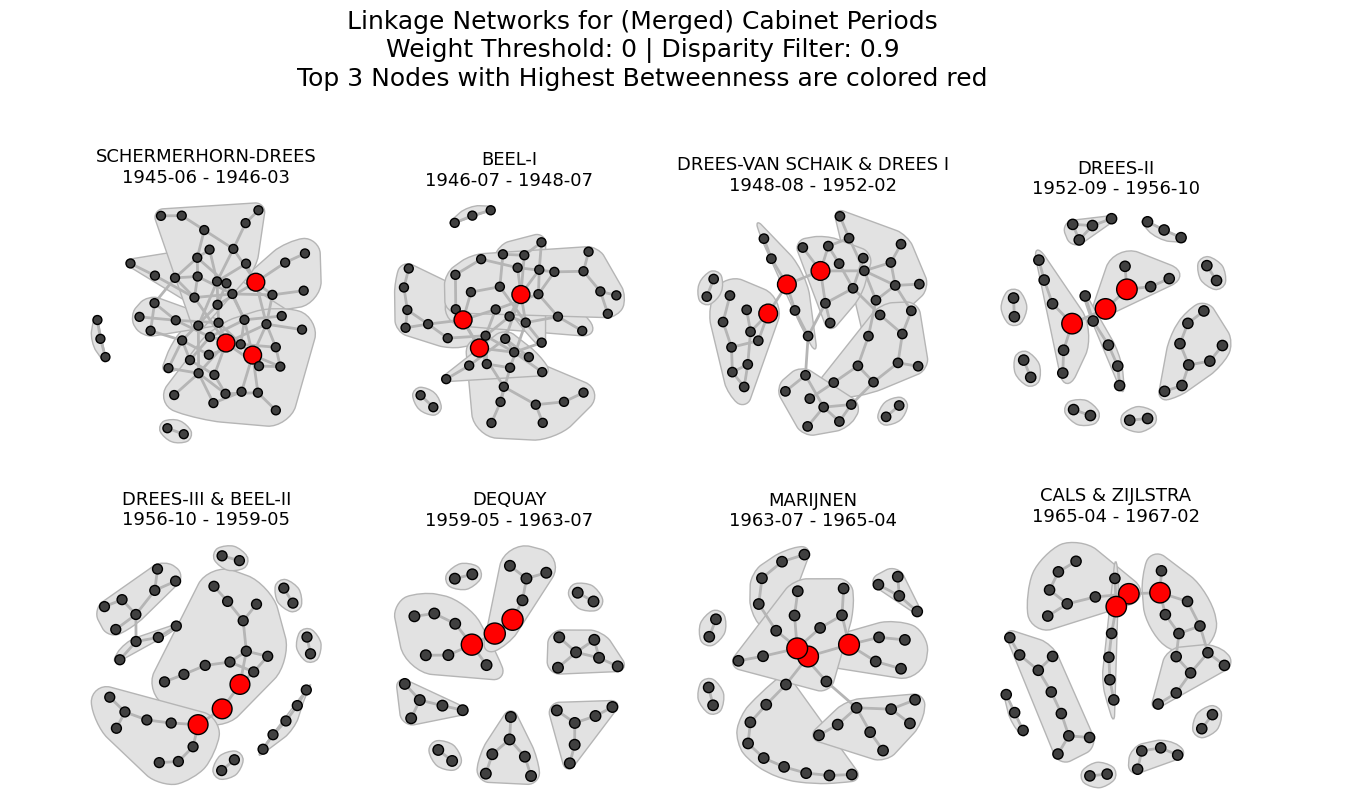

In [29]:
fig = plt.figure(figsize=(15,8))

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)
    theta_flat = flatten_mi_array(theta)
    theta_flat.columns = ['src','trg','nij']
    theta_flat = theta_flat[~theta_flat.src.isin(indices_nonsem)]
    theta_flat = theta_flat[~theta_flat.trg.isin(indices_nonsem)]
    theta_flat = theta_flat[theta_flat.nij > 0]
    theta_flat = disparity_filter(theta_flat)
    theta_flat = theta_flat[theta_flat.score >= 0.8].drop(['variance','score'],axis=1)
    theta_flat.columns = ['source','target','weight']

    g,comm,edge_df = get_network_from_edge_dataframe(edge_df=theta_flat,node_text='labels',labels=labels)
    betweenness_values = get_betweenness_values(g)
    top_btw = Counter(dict(betweenness_values)).most_common(3)

    grey_pal_light_dark = sns.color_palette('Greys',4)

    visual_style = dict()
    visual_style["edge_curved"] = False
    visual_style["edge_color"] = [igraph.color_name_to_rgba('lightgrey') for e in g.es]
    visual_style["vertex_label"] = g.vs["name"]
    visual_style["vertex_label_size"] = 12
    visual_style["vertex_label_alpha"] = 0
    visual_style["vertex_size"] = [.5 if e['name'] not in dict(top_btw).keys() else 1 for e in g.vs]
    visual_style['vertex_color'] = [grey_pal_light_dark[-1] if e['name'] not in dict(top_btw).keys() else 'red' for e in g.vs]
    visual_style['margin'] = 10
    visual_style['bbox'] = (0, 0, 1500, 1000)

    ax = plt.subplot(2, 4, c + 1)
    cabinet = r['cabinet'].upper()
    s,e = r['startdate'].strftime('%Y-%m'), r['enddate'].strftime('%Y-%m')
    title = f"{cabinet}\n{s} - {e}"
    ax.set_title(title,fontsize=(13))
    layout = g.layout_fruchterman_reingold()
    igraph.plot(comm,mark_groups = True,target=ax,layout=layout,**visual_style)

    for i in ax.get_children():
        if isinstance(i,matplotlib.patches.PathPatch):
            i.set_edgecolor(grey_pal_light_dark[1])
            i.set_facecolor(grey_pal_light_dark[0])
        elif isinstance(i,matplotlib.text.Text):
            if len(i.get_text()) != 4 and i.get_text() != title:
                i.set_alpha(0)

    # clusters = [[labels[x] for x in l if 'rhet' not in labels[x] and 'proc' not in labels[x]] for l in list(cmty)]
    # print(r['cabinet'])
    # for c in clusters:
    #     print(', '.join(c))

fig = plt.gcf()
fig.suptitle("Linkage Networks for (Merged) Cabinet Periods\nWeight Threshold: 0 | Disparity Filter: 0.9\nTop 3 Nodes with Highest Betweenness are colored red", fontsize=18,y=1.1)
plt.savefig('figs/networks-cabinets-filters.pdf',dpi=250)
plt.subplots_adjust(hspace=.25)
plt.show()

/home/rb/Documents/GitHub/linkage/helpers/networks.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df['source']  = edge_df['source'].apply(lambda x: labels[x])
/home/rb/Documents/GitHub/linkage/helpers/networks.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df['target']  = edge_df['target'].apply(lambda x: labels[x])
/home/rb/Documents/GitHub/linkage/helpers/networks.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

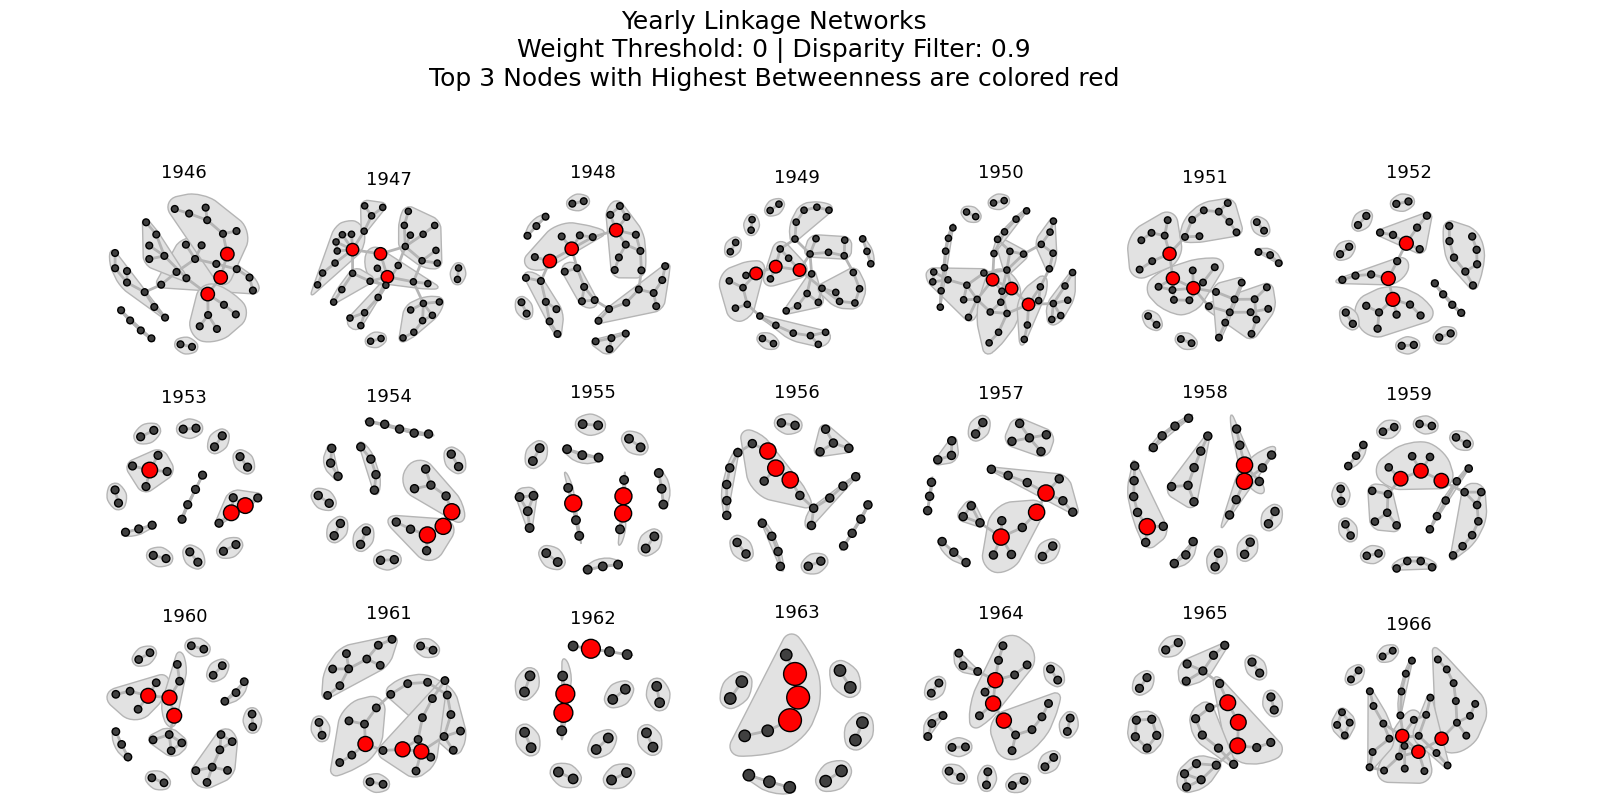

In [30]:
fig = plt.figure(figsize=(18,8))

for c,(year,theta) in enumerate(dists.groupby(dists.index.to_period('Y'))):
    theta,_,__ = mutual_information(theta.to_numpy())
    theta_flat = flatten_mi_array(theta)
    theta_flat.columns = ['src','trg','nij']
    theta_flat = theta_flat[~theta_flat.src.isin(indices_nonsem)]
    theta_flat = theta_flat[~theta_flat.trg.isin(indices_nonsem)]
    theta_flat = theta_flat[theta_flat.nij > 0]
    theta_flat = disparity_filter(theta_flat)
    theta_flat = theta_flat[theta_flat.score >= 0.8].drop(['variance','score'],axis=1)
    theta_flat.columns = ['source','target','weight']

    g,cmty,stdf = get_network_from_edge_dataframe(edge_df=theta_flat,node_text='labels',labels=labels,thr=0.75)
    betweenness_values = get_betweenness_values(g)
    top_btw = Counter(dict(betweenness_values)).most_common(3)

    grey_pal_light_dark = sns.color_palette('Greys',4)

    visual_style = dict()
    visual_style["edge_curved"] = False
    visual_style["edge_color"] = [igraph.color_name_to_rgba('lightgrey') for e in g.es]
    visual_style["vertex_label"] = g.vs["name"]
    visual_style["vertex_label_size"] = 12
    visual_style["vertex_label_alpha"] = 0
    visual_style["vertex_size"] = [.5 if e['name'] not in dict(top_btw).keys() else 1 for e in g.vs]
    visual_style['vertex_color'] = [grey_pal_light_dark[-1] if e['name'] not in dict(top_btw).keys() else 'red' for e in g.vs]
    visual_style['margin'] = 10
    visual_style['bbox'] = (0, 0, 1500, 1000)

    ax = plt.subplot(3, 7, c + 1)
    ax.set_title(str(year),fontsize=(13))
    layout = g.layout_fruchterman_reingold()
    igraph.plot(cmty,mark_groups = True,target=ax,layout=layout,**visual_style)

    for i in ax.get_children():
        if isinstance(i,matplotlib.patches.PathPatch):
            i.set_edgecolor(grey_pal_light_dark[1])
            i.set_facecolor(grey_pal_light_dark[0])
        elif isinstance(i,matplotlib.text.Text):
            if len(i.get_text()) != 4:
                i.set_alpha(0)


    # clusters = [[labels[x] for x in l if 'rhet' not in labels[x] and 'proc' not in labels[x]] for l in list(cmty)]
    # print(r['cabinet'])
    # for c in clusters:
    #     print(', '.join(c))
    
fig = plt.gcf()
fig.suptitle("Yearly Linkage Networks\nWeight Threshold: 0 | Disparity Filter: 0.9\nTop 3 Nodes with Highest Betweenness are colored red", fontsize=18,y=1.1)
plt.savefig('figs/networks-years-filters.pdf',dpi=250)
plt.subplots_adjust(hspace=.25)
plt.show()

# Plot Cabinet

In [3]:
cab_

,startdate,enddate,cabinet,num_departments,num_ministers
0,1945-06-25,1946-03-07,Schermerhorn-Drees,14,15
1,1946-07-03,1948-07-08,Beel-I,17,19
2,1948-08-07,1952-02-09,Drees-Van Schaik & Drees I,14,21
3,1952-09-02,1956-10-13,Drees-II,15,24
4,1956-10-13,1959-05-19,Drees-III & Beel-II,15,24
5,1959-05-19,1963-07-24,DeQuay,14,26
6,1963-07-24,1965-04-14,Marijnen,14,26
7,1965-04-14,1967-02-15,Cals & Zijlstra,14,28


warning, no disparity and/or weight filter applied


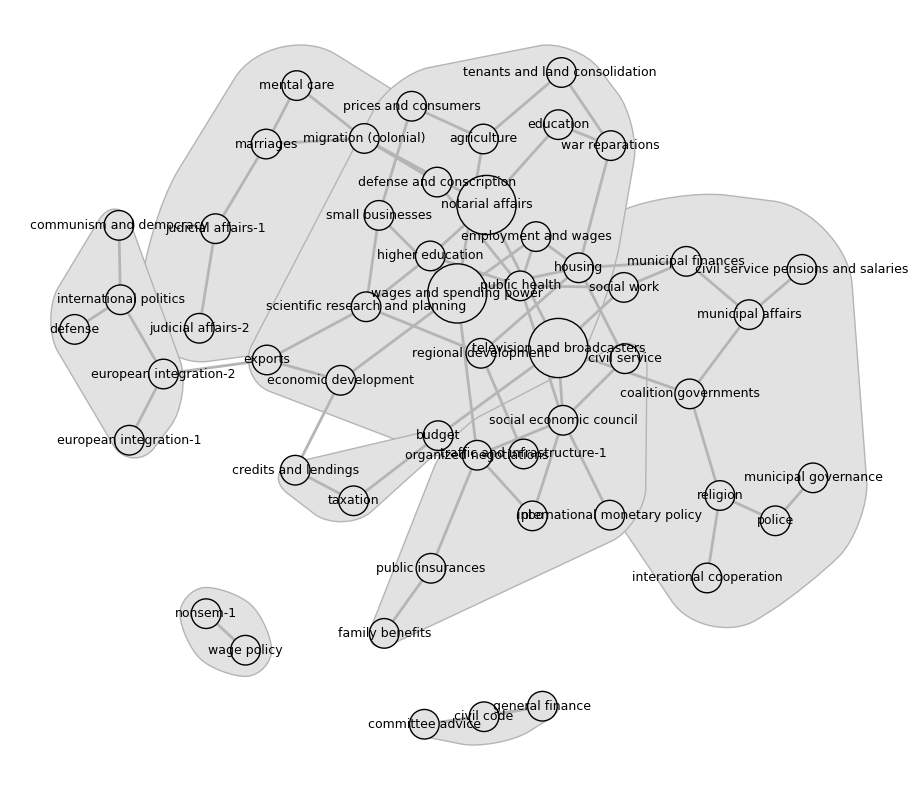

In [15]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
r = cab_[cab_.cabinet == 'Beel-I'].to_dict('records')[0]
mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
theta = dists.loc[mask].to_numpy()
theta,_,__ = mutual_information(theta)
theta_flat = flatten_mi_array(theta)
theta_flat.columns = ['src','trg','nij']
theta_flat = theta_flat[~theta_flat.src.isin(indices_nonsem)]
theta_flat = theta_flat[~theta_flat.trg.isin(indices_nonsem)]

theta_flat = theta_flat[theta_flat.nij > 0]
theta_flat = disparity_filter(theta_flat)
theta_flat = theta_flat[theta_flat.score >= 0.8].drop(['variance','score'],axis=1)
theta_flat.columns = ['source','target','weight']

g,comm,edge_df = get_network_from_edge_dataframe(edge_df=theta_flat,node_text='labels',labels=labels)
betweenness_values = get_betweenness_values(g)
top_btw = Counter(dict(betweenness_values)).most_common(3)

grey_pal_light_dark = sns.color_palette('Greys',4)

visual_style = dict()
visual_style["edge_curved"] = False
visual_style["edge_color"] = [igraph.color_name_to_rgba('lightgrey') for e in g.es]
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_label_size"] = 9
visual_style["vertex_label_alpha"] = 0
visual_style["vertex_size"] = [.5 if e['name'] not in dict(top_btw).keys() else 1 for e in g.vs]
# visual_style['vertex_color'] = [grey_pal_light_dark[0] if e['name'] not in dict(top_btw).keys() else 'red' for e in g.vs]
visual_style['vertex_color'] = [grey_pal_light_dark[0] for e in g.vs]
visual_style['margin'] = 10
visual_style['bbox'] = (0, 0, 1500, 2500)

layout = g.layout_fruchterman_reingold()
igraph.plot(comm,mark_groups = True,target=ax,layout=layout,**visual_style)

dg_th = [k for k,v in get_degree_values(g) if v > 1]
for i in ax.get_children():
    if isinstance(i,matplotlib.patches.PathPatch):
        i.set_edgecolor(grey_pal_light_dark[1])
        i.set_facecolor(grey_pal_light_dark[0])
    # elif isinstance(i,matplotlib.text.Text):
        # if len(i.get_text()) != 4 and i.get_text() != title and i.get_text() not in dg_th:
        #     i.set_alpha(0)

# Plot Year

warning, no disparity and/or weight filter applied


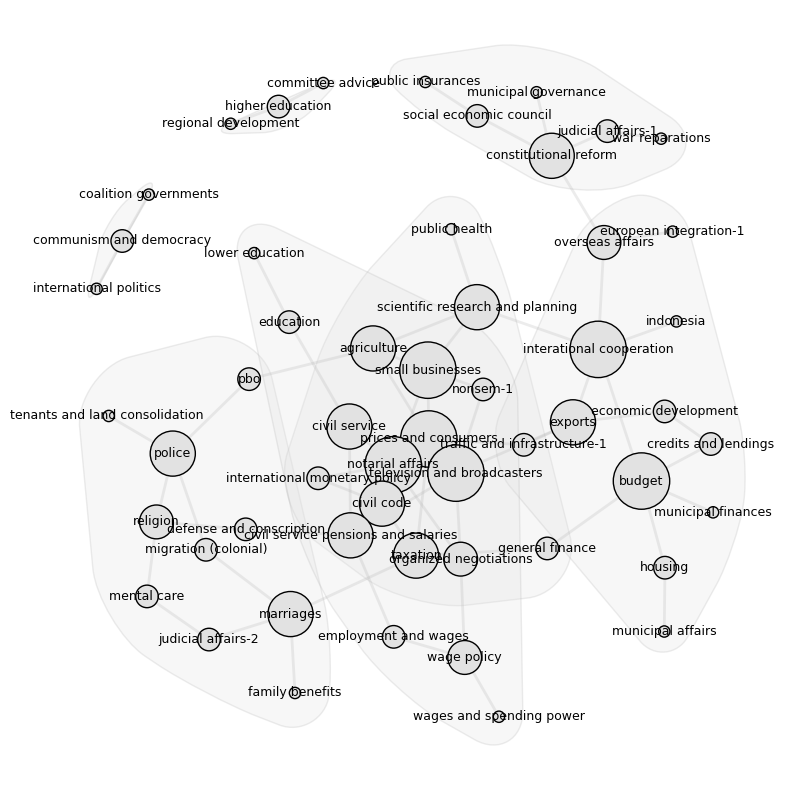

In [39]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
year = 1961

mask = (dists.index.year == year)
theta = dists.loc[mask].to_numpy()
theta,_,__ = mutual_information(theta)
theta_flat = flatten_mi_array(theta)
theta_flat.columns = ['src','trg','nij']
theta_flat = theta_flat[~theta_flat.src.isin(indices_nonsem)]
theta_flat = theta_flat[~theta_flat.trg.isin(indices_nonsem)]

theta_flat = theta_flat[theta_flat.nij > 0]
theta_flat = disparity_filter(theta_flat)
theta_flat = theta_flat[theta_flat.score >= 0.8].drop(['variance','score'],axis=1)
theta_flat.columns = ['source','target','weight']

g,comm,edge_df = get_network_from_edge_dataframe(edge_df=theta_flat,node_text='labels',labels=labels)
betweenness_values = get_betweenness_values(g)
top_btw = Counter(dict(betweenness_values)).most_common(3)

grey_pal_light_dark = sns.color_palette('Greys',4)

visual_style = dict()
visual_style["edge_curved"] = False
visual_style["edge_color"] = [igraph.color_name_to_rgba('lightgrey') for e in g.es]
# visual_style["edge_width"] = 
visual_style["vertex_label"] = g.vs["name"]
visual_style["vertex_label_size"] = 9
visual_style["vertex_label_alpha"] = 0
# visual_style["vertex_size"] = [.5 if e['name'] not in dict(top_btw).keys() else 1 for e in g.vs]
visual_style['vertex_size'] = [i / 5 for i in list(g.degree())]
# visual_style['vertex_color'] = [grey_pal_light_dark[0] if e['name'] not in dict(top_btw).keys() else 'red' for e in g.vs]
visual_style['vertex_color'] = [grey_pal_light_dark[0] for e in g.vs]
visual_style['margin'] = 10
visual_style['bbox'] = (0, 0, 1500, 2500)

layout = g.layout_fruchterman_reingold()
igraph.plot(comm,mark_groups = True,target=ax,layout=layout,**visual_style)

dg_th = [k for k,v in get_degree_values(g) if v > 1]
for i in ax.get_children():
    if isinstance(i,matplotlib.patches.PathPatch):
        i.set_edgecolor(grey_pal_light_dark[1])
        i.set_facecolor(grey_pal_light_dark[0])
        i.set_alpha(.25)
    # elif isinstance(i,matplotlib.text.Text):
        # if len(i.get_text()) != 4 and i.get_text() != title and i.get_text() not in dg_th:
        #     i.set_alpha(0)